# IMPORT LIBRARY

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# IMPORT DATASET

In [2]:
# read the data using pandas dataframe
df = pd.read_csv('Train_Titanic.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EXPLORE/VISUALIZE DATASET

### target variable

In [3]:
Survived    = df[df['Survived']==1]
No_Survived = df[df['Survived']==0]

print("Total =", len(df))

print("Number of customers who Survived =", len(Survived))
print("Percentage bought =", 1.*len(Survived)/len(df)*100.0, "%")
 
print("Did not Survived =", len(No_Survived))
print("Percentage who did not Survived =", 1.*len(No_Survived)/len(df)*100.0, "%")

Total = 891
Number of customers who Survived = 342
Percentage bought = 38.38383838383838 %
Did not Survived = 549
Percentage who did not Survived = 61.61616161616161 %


Text(0.5, 1.0, 'Survived Distribution \n (0: No Survived || 1: Survived)')

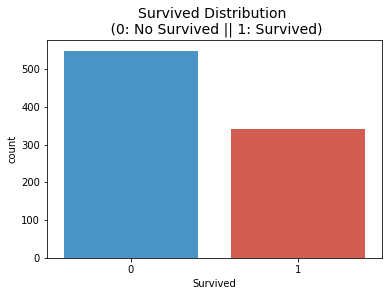

In [4]:
colors = ["#3498db","#e74c3c"]

sns.countplot('Survived', data=df,palette = colors)
plt.title('Survived Distribution \n (0: No Survived || 1: Survived)', fontsize = 14)

# DATA PREPARATION

### Missing data

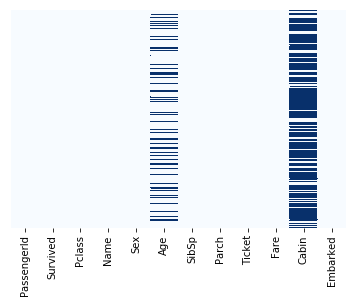

In [5]:
# Let's explore which dataset is missing
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [6]:
org_df = df
removed_features = ['Cabin','Name','Embarked','Ticket','PassengerId']
selected_featues = [e for e in df.columns if e not in removed_features]
selected_featues

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
df = org_df.loc[:,selected_featues]

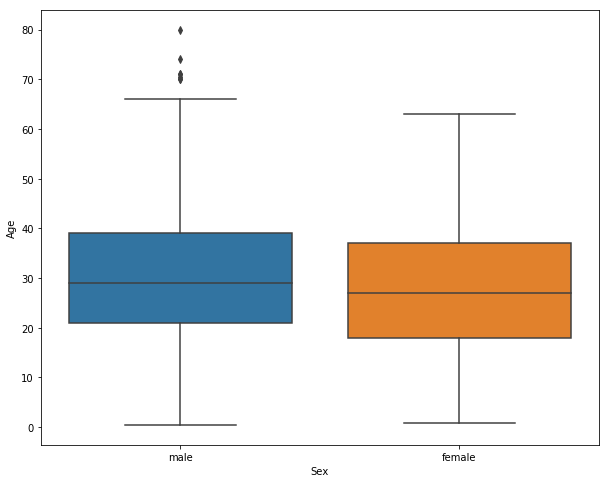

In [8]:
# Let's get the average age for male (~29) and female (~25)
plt.figure(figsize=(10, 8))
sns.boxplot(x='Sex', y='Age',data=df)

In [9]:
def Fill_Age(data):
    age = data[0]
    sex = data[1]

    if pd.isnull(age):
        if sex is 'male': 
            return 29
        else:
            return 25
    else:
        return age

In [10]:
df['Age'] = df[['Age','Sex']].apply(Fill_Age,axis=1)

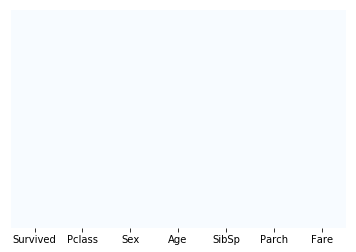

In [11]:
# Let's view the data one more time!
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [13]:
male = pd.get_dummies(df['Sex'], drop_first = True)
# first let's drop the embarked and sex 
df.drop(['Sex'], axis = 1, inplace = True)
# Now let's add the encoded column male again
df = pd.concat([df, male], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


### Split data into X and y

In [14]:
X = df.drop('Survived',axis=1)
y = df.Survived

### Data Normalization

In [15]:
from sklearn.preprocessing import  StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = X
X_scaled.Age = scaler.fit_transform(X_scaled.Age.reshape(-1,1))
X_scaled.Fare = scaler.fit_transform(X_scaled.Fare.reshape(-1,1))
X_scaled.Pclass = scaler.fit_transform(X_scaled.Pclass.reshape(-1,1))
X_scaled.head()

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Pclass,Age,SibSp,Parch,Fare,male
0,1.0,0.271174,1,0,0.014151,1
1,0.0,0.472229,1,0,0.139136,0
2,1.0,0.321438,0,0,0.015469,0
3,0.0,0.434531,1,0,0.103644,0
4,1.0,0.434531,0,0,0.015713,1


### Split data into train-test split

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

# AutoEncoder

In [16]:
####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
# from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex
import datetime

Using TensorFlow backend.


In [108]:
#set up graphic style in this case I am using the color scheme from xkcd.com
LABELS = ["No Survived","Survived"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [17]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


In [59]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state = 101)

X_train = X_train[X_train['Survived'] == 0]
X_train = X_train.drop(['Survived'], axis = 1)
y_test = X_test['Survived']
X_test = X_test.drop(['Survived'], axis = 1)
X_train = X_train.values
X_test = X_test.values
print('Training data size: ', X_train.shape)
print('Validation data size: ', X_test.shape)

Training data size:  (450, 6)
Validation data size:  (179, 6)


In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
X_train_scaled

array([[0.5       , 0.30136986, 0.        , 0.        , 0.04942966,
        1.        ],
       [1.        , 0.32876712, 0.        , 0.        , 0.03094106,
        0.        ],
       [1.        , 0.50684932, 0.        , 0.        , 0.03293726,
        1.        ],
       ...,
       [1.        , 0.32876712, 0.        , 0.        , 0.02908745,
        1.        ],
       [1.        , 0.24657534, 0.        , 0.        , 0.05513308,
        1.        ],
       [1.        , 0.32876712, 1.        , 0.33333333, 0.26444867,
        0.        ]])

In [62]:
# No of Neurons in each Layer [6,4,2,4,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(4), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(2), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(4), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [146]:
# No of Neurons in each Layer [6,3,1,3,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(3), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(1), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(3), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 4         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 24        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [184]:
# No of Neurons in each Layer [6,4,1,4,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(4), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(1), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(4), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 30        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [185]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

cp = ModelCheckpoint(filepath="autoencoder1.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

t_ini = datetime.datetime.now()


history = autoencoder.fit(X_train_scaled, X_train_scaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, tb]).history

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history)

Train on 405 samples, validate on 45 samples
Epoch 1/100
405/405 [==============================] - 0s 597us/step - loss: 0.4150 - val_loss: 0.3782
Epoch 2/100
405/405 [==============================] - 0s 27us/step - loss: 0.3781 - val_loss: 0.3436
Epoch 3/100
405/405 [==============================] - 0s 33us/step - loss: 0.3456 - val_loss: 0.3135
Epoch 4/100
405/405 [==============================] - 0s 28us/step - loss: 0.3179 - val_loss: 0.2883
Epoch 5/100
405/405 [==============================] - 0s 26us/step - loss: 0.2947 - val_loss: 0.2677
Epoch 6/100
405/405 [==============================] - 0s 32us/step - loss: 0.2755 - val_loss: 0.2507
Epoch 7/100
405/405 [==============================] - 0s 27us/step - loss: 0.2593 - val_loss: 0.2360
Epoch 8/100
405/405 [==============================] - 0s 32us/step - loss: 0.2452 - val_loss: 0.2230
Epoch 9/100
405/405 [==============================] - 0s 28us/step - loss: 0.2326 - val_loss: 0.2113
Epoch 10/100
405/405 [==============

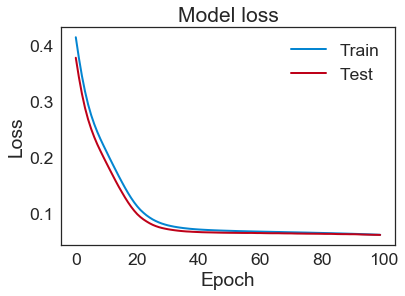

In [186]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [187]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()

,Label,reconstruction_error
count,179.000000,179.000000
mean,0.446927,0.091661
std,0.498570,0.087285
min,0.000000,0.013516
25%,0.000000,0.018328
50%,0.000000,0.069903
75%,1.000000,0.133605
max,1.000000,0.685313


In [188]:
df_error.head()

,Label,reconstruction_error
331,0,0.086201
700,1,0.316518
748,0,0.077284
751,1,0.035841
481,0,0.014166


C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


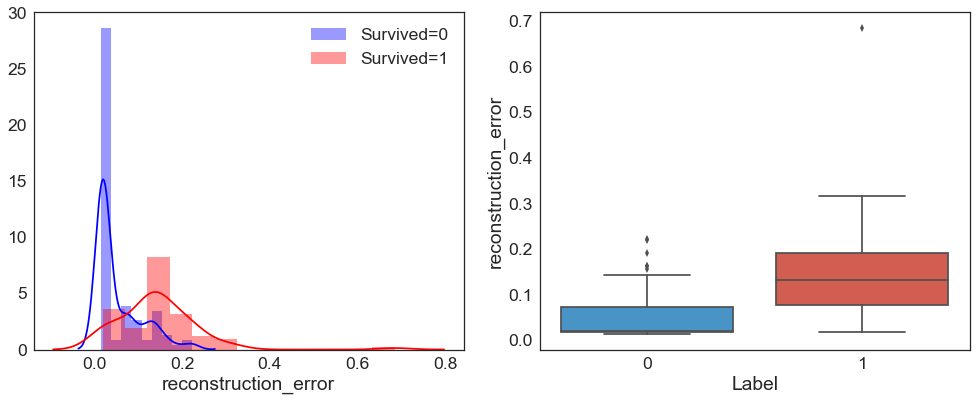

In [189]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6))
sns.distplot(df_error.loc[df_error.Label==0,'reconstruction_error'],color='blue', ax=ax1, label='Survived=0')
sns.distplot(df_error.loc[df_error.Label==1,'reconstruction_error'],color='red', ax=ax1, label='Survived=1')
ax2 = sns.boxplot(x='Label', y='reconstruction_error', data=df_error, palette=colors)
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [190]:
# change X_tes_scaled to pandas dataframe
numerical_cols = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6']
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns = numerical_cols)
data_n.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.0,0.609589,0.000,0.000000,0.108365,1.0
700,0.0,0.232877,0.125,0.000000,0.865114,0.0
748,0.0,0.246575,0.125,0.000000,0.201901,1.0
751,1.0,0.068493,0.000,0.166667,0.047433,1.0
481,0.5,0.328767,0.000,0.000000,0.000000,1.0


In [191]:
reconstrcuted_df = autoencoder.predict(data_n)
reconstrcuted_df = pd.DataFrame(reconstrcuted_df, index= data_n.index.values)

In [192]:
reconstrcuted_df.columns = data_n.columns.values
reconstrcuted_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.615801,0.336427,0.003936,-0.029446,0.072776,0.752559
700,0.756853,0.397444,0.077654,0.069398,0.089981,0.831449
748,0.594788,0.328915,-0.005524,-0.041984,0.070565,0.740960
751,0.751855,0.394827,0.074653,0.065336,0.089306,0.828587
481,0.674536,0.359186,0.032195,0.008216,0.079438,0.785077


In [193]:
RE_per_dim_df = abs(data_n - reconstrcuted_df)
RE_per_dim_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.615801,0.273162,0.003936,0.029446,0.035589,0.247441
700,0.756853,0.164568,0.047346,0.069398,0.775133,0.831449
748,0.594788,0.082339,0.130524,0.041984,0.131337,0.259040
751,0.248145,0.326334,0.074653,0.101331,0.041873,0.171413
481,0.174536,0.030419,0.032195,0.008216,0.079438,0.214923


In [195]:
RE_per_dim_df['Survived'] = y_test
RE_per_dim_df['reconstruction_error'] = df_error['reconstruction_error']
RE_per_dim_df.head(10)

,V_1,V_2,V_3,V_4,V_5,V_6,Survived,reconstruction_error
331,0.615801,0.273162,0.003936,0.029446,0.035589,0.247441,0,0.086201
700,0.756853,0.164568,0.047346,0.069398,0.775133,0.831449,1,0.316518
748,0.594788,0.082339,0.130524,0.041984,0.131337,0.259040,0,0.077284
751,0.248145,0.326334,0.074653,0.101331,0.041873,0.171413,1,0.035841
481,0.174536,0.030419,0.032195,0.008216,0.079438,0.214923,0,0.014166
845,0.234909,0.159780,0.082679,0.076206,0.062393,0.163816,0,0.020681
740,0.579472,0.005157,0.012232,0.050853,0.045061,0.267495,1,0.068689
287,0.249548,0.106429,0.073816,0.064205,0.059095,0.172215,0,0.019387
669,0.680849,0.033050,0.089585,0.012525,0.117520,0.788590,1,0.184752
241,0.213447,0.085307,0.028747,0.094645,0.035107,0.848637,1,0.130673


### ROC Curve Check

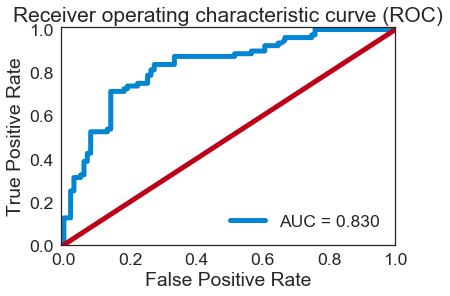

In [196]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_error.Label, df_error.reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [197]:
roc_auc

0.8296085858585858

In [198]:
ROC_df = pd.DataFrame()
ROC_df['false_pos_rate'] = false_pos_rate
ROC_df['true_pos_rate'] = true_pos_rate
ROC_df['thresholds'] = thresholds
ROC_df.head(25)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.0000,1.685313
1,0.000000,0.0125,0.685313
2,0.000000,0.1250,0.229567
3,0.020202,0.1250,0.219885
4,0.020202,0.2500,0.195211
5,0.030303,0.2500,0.191521
6,0.030303,0.3125,0.170506
7,0.050505,0.3125,0.162883
8,0.050505,0.3250,0.161851
9,0.060606,0.3250,0.157093


### Recall vs. Precision Thresholding

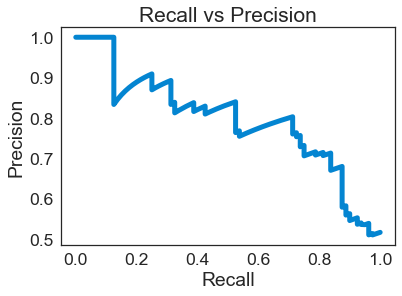

In [199]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(df_error.Label, df_error.reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [200]:
PR_df = pd.DataFrame()
PR_df['precision_rt'] = precision_rt[1:len(threshold_rt)]
PR_df['recall_rt'] = recall_rt[1:len(threshold_rt)]
PR_df['threshold_rt'] = threshold_rt[1:len(threshold_rt)]
PR_df.head(20)

,precision_rt,recall_rt,threshold_rt
0,0.512987,0.9875,0.017554
1,0.509804,0.9750,0.017733
2,0.513158,0.9750,0.017745
3,0.509934,0.9625,0.017747
4,0.513333,0.9625,0.017826
5,0.516779,0.9625,0.017875
6,0.520270,0.9625,0.018032
7,0.527397,0.9625,0.018048
8,0.538462,0.9625,0.018060
9,0.535211,0.9500,0.018062


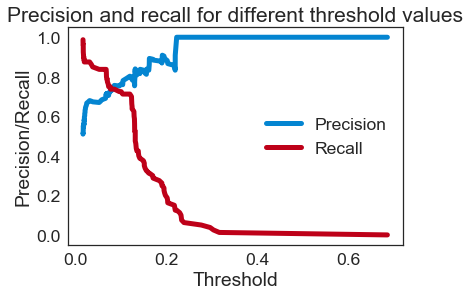

In [201]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Reconstruction Error vs Threshold Check

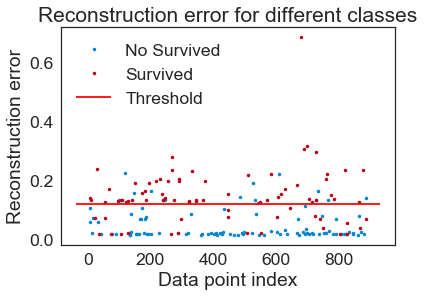

In [205]:
threshold_fixed = 0.12
groups = df_error.groupby('Label')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Survived" if name == 1 else "No Survived")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

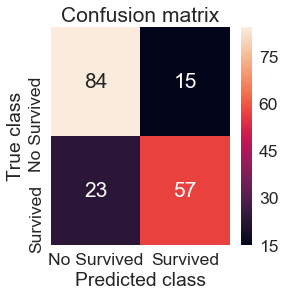

In [206]:
pred_y = [1 if e > threshold_fixed else 0 for e in df_error.reconstruction_error.values]
conf_matrix = confusion_matrix(df_error.Label, pred_y)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [207]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.79      0.71      0.75        80

   micro avg       0.79      0.79      0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

